# 1. Import the libraries

In [1]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 21.12.2 requires cupy-cuda115, which is not installed.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
tfx-bsl 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
tensorflow-transform 1.12.0 requires pyarrow<7,>=6, but you have pyarrow 5.0.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random 
import os

# 2. Define Image properties

In [3]:
Image_width = 150
Image_height = 150
Image_size = (Image_width, Image_height)
Image_channels = 3

# 3. Prepare dataset for training model

In [4]:
# !cd /kaggle/input/dogs-vs-cats/train.zip

In [5]:
# !yes|unzip -q train.zip -d train

In [6]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [7]:
!unzip -q "/kaggle/input/dogs-vs-cats/test1.zip"
!unzip -q "/kaggle/input/dogs-vs-cats/train.zip"

In [8]:
ls

__notebook__.ipynb  test1/  train/


In [9]:
train_dir = '/kaggle/working/train'
test_dir = '/kaggle/working/test1'

In [10]:
categories = []

for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

# 4. Create the neutral net model:

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization,Conv2D,MaxPooling2D,Dropout,Flatten,Dense
)
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'relu',input_shape = (Image_width,Image_height,Image_channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation = 'softmax'))

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             optimizer = 'adam',metrics = ['accuracy'])

# 5. Analyzing Model

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 72, 72, 64)       2

# 6. Define callbacks and learning rate:

In [13]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

# 7. Manage Data

In [14]:
# create folders and move files
if not os.path.exists((os.path.join(train_dir, 'cat'))):
    os.mkdir(os.path.join(train_dir, 'cat'))
if not os.path.exists((os.path.join(train_dir, 'dog'))):
    os.mkdir(os.path.join(train_dir, 'dog'))

for file in os.listdir(train_dir):
    if file[-3] == 'j':
        if file[0] == 'c':
            os.replace(os.path.join(train_dir,file), os.path.join(train_dir,'cat', file))
        else:
            os.replace(os.path.join(train_dir,file), os.path.join(train_dir,'dog', file))

In [15]:
filenames = os.listdir('/kaggle/working/train')

categories = []
for f_name in filenames:
    category = f_name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
        
df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [16]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})
train_df,validate_df = train_test_split(df,test_size=0.20,
  random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

In [17]:
Batch_size = 100 # Number of trainin examples to process before updating our models variables
Img_shape = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

# 8. Training and validation data generator:

In [18]:
image_generator = ImageDataGenerator(rescale=1./255, validation_split = 0.2)

In [19]:
train_data_gen = image_generator.flow_from_directory(
    batch_size = Batch_size,
    directory = train_dir,
    shuffle = True,
    target_size = (Img_shape,Img_shape), #(150,150)
    class_mode = 'binary',
    subset = 'training'
)

val_data_gen = image_generator.flow_from_directory(
    batch_size = Batch_size,
    directory = train_dir,
    shuffle = False,
    target_size = (Img_shape,Img_shape), #(150,150)
    class_mode = 'binary',
    subset = 'validation'
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# 9. Model Training

In [20]:
epochs = 10
history = model.fit_generator(
    train_data_gen,
    epochs = epochs,
    validation_data = val_data_gen,
    steps_per_epoch = int(np.ceil(20000 / float(Batch_size))), #batch_size
    validation_steps = int(np.ceil(5000 / float(Batch_size))) #batch_size
#     callbacks = callbacks
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/10


/opt/conda/lib/python3.7/site-packages/keras/backend.py:5586: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits, "Softmax", "sparse_categorical_crossentropy"
2023-04-22 10:24:07.168684: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


200/200 [==============================] - 81s 358ms/step - loss: 0.7672 - accuracy: 0.6615 - val_loss: 1.4723 - val_accuracy: 0.5000
Epoch 2/10
200/200 [==============================] - 71s 354ms/step - loss: 0.5103 - accuracy: 0.7612 - val_loss: 1.6791 - val_accuracy: 0.5040
Epoch 3/10
200/200 [==============================] - 71s 352ms/step - loss: 0.4196 - accuracy: 0.8102 - val_loss: 0.5674 - val_accuracy: 0.7242
Epoch 4/10
200/200 [==============================] - 71s 356ms/step - loss: 0.3537 - accuracy: 0.8457 - val_loss: 0.5664 - val_accuracy: 0.7598
Epoch 5/10
200/200 [==============================] - 71s 353ms/step - loss: 0.2970 - accuracy: 0.8748 - val_loss: 0.4369 - val_accuracy: 0.8320
Epoch 6/10
200/200 [==============================] - 75s 373ms/step - loss: 0.2441 - accuracy: 0.8996 - val_loss: 0.6240 - val_accuracy: 0.7856
Epoch 7/10
200/200 [==============================] - 72s 362ms/step - loss: 0.2073 - accuracy: 0.9179 - val_loss: 0.3964 - val_accuracy: 0.8

# 10. Visualize Results of the training

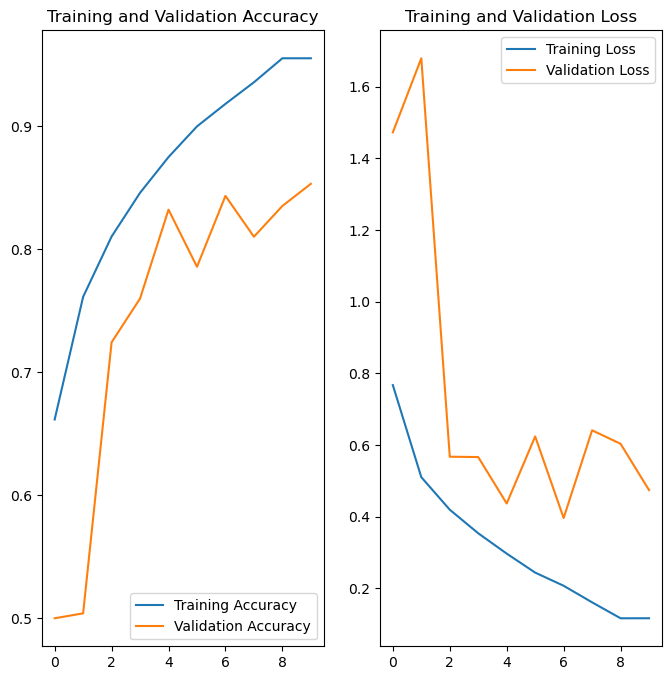

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label = 'Training Accuracy')
plt.plot(epochs_range,val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label = 'Training Loss')
plt.plot(epochs_range,val_loss,label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig('foo.png')
plt.show()

# 11. Save the model

In [22]:
model.save('model1_DogsVsCats_epoch10.h5')

# 12. Test data preparation

In [23]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# 13. Make categorical prediction:

In [24]:
test_data_gen = image_generator.flow_from_directory(
    batch_size = Batch_size,
    directory = test_dir,
    shuffle = True,
    target_size = (Img_shape,Img_shape), #(150,150)
    class_mode = 'binary',
    subset = 'training'
)

val_data_gen = image_generator.flow_from_directory(
    batch_size = Batch_size,
    directory = test_dir,
    shuffle = False,
    target_size = (Img_shape,Img_shape), #(150,150)
    class_mode = 'binary',
    subset = 'validation'
)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [25]:
# predict = model.predict_generator(test_data_gen,steps = np.ceil(nb_samples/batch_size))

# 14. Converts labels to Categories

In [26]:
# test_df['category'] = np.argmax(predict, axis = 1)

# label_map = dict((v,k) for k,v in train_data_gen.class_indices.items())
# test_df['category'] = test_df['category'].replace(label_map)

# test_df['category'] = test_df['category'].replace({'dog':1,'cat':0})

# 15. Visualize the Prediction Results:

In [27]:
# sample_test = test_dir
# # sample_test.head()
# plt.figure(figsize = (12,24))
# for index,row in sample_test.iterrows():
#     filename = row['filename']
#     category = row['category']
#     img = load_img('/kaggle/working/test1' + filename,target_size = Image_size)
#     plt.subplot(6,3,index+1)
#     plt.imshow(img)
#     plt.xlabel(filename+'('+'{}'.format(category)+')')
# plt.tight_layout()
# plt.show()

# 16. Test your model on custom data:

In [28]:
# results = {
#     0:'cat',
#     1:'dog'
# }
# from PIL import Image
# import numpy as np
# im = Image.open("_image_path_TO_custom_image")
# im = im.resize(Image_Size)
# im = np.expand_dims(im,axis = 0)
# im = np.array(im)
# im = im/255
# pred = model.predict_classes([im])[0]
# print(pred,results[pred])

# 17. Dogs Vs Cats Calssifier GUI:

In [29]:
# import tkinter as tk
# from tkinter import filedialog
# from tkinter import *
# from PIL import ImageTk, Image
# import numpy

# from tensorflow.keras.models import load_model
# model = load_model('model1_DogsVsCats_epoch10.h5')
# #dictionary to label all traffic signs class.
# classes = { 
#     0:'its a cat',
#     1:'its a dog',
 
# }
# #initialise GUI
# top=tk.Tk()
# top.geometry('800x600')
# top.title('CatsVSDogs Classification')
# top.configure(background='#CDCDCD')
# label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
# sign_image = Label(top)
# def classify(file_path):
#     global label_packed
#     image = Image.open(file_path)
#     image = image.resize((128,128))
#     image = numpy.expand_dims(image, axis=0)
#     image = numpy.array(image)
#     image = image/255
#     pred = model.predict_classes([image])[0]
#     sign = classes[pred]
#     print(sign)
#     label.configure(foreground='#011638', text=sign) 
# def show_classify_button(file_path):
#     classify_b=Button(top,text="Classify Image",
#    command=lambda: classify(file_path),
#    padx=10,pady=5)
#     classify_b.configure(background='#364156', foreground='white',
# font=('arial',10,'bold'))
#     classify_b.place(relx=0.79,rely=0.46)

# def upload_image():
#     try:
#         file_path=filedialog.askopenfilename()
#         uploaded=Image.open(file_path)
#         uploaded.thumbnail(((top.winfo_width()/2.25),
#     (top.winfo_height()/2.25)))
#         im=ImageTk.PhotoImage(uploaded)
#         sign_image.configure(image=im)
#         sign_image.image=im
#         label.configure(text='')
#         show_classify_button(file_path)
#     except:
#         pass
# upload=Button(top,text="Upload an image",command=upload_image,padx=10,pady=5)
# upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
# upload.pack(side=BOTTOM,pady=50)
# sign_image.pack(side=BOTTOM,expand=True)
# label.pack(side=BOTTOM,expand=True)
# heading = Label(top, text="CatsVSDogs Classification",pady=20, font=('arial',20,'bold'))
# heading.configure(background='#CDCDCD',foreground='#364156')
# heading.pack()
# top.mainloop()